In [15]:
#!/usr/bin/env python3
# -*- coding:utf-8 -*-
import os
import json
import re
import csv
from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix,f1_score,roc_auc_score,roc_curve
import matplotlib.pyplot as plt
import math
import nltk
from nltk.corpus import stopwords
np.random.seed(1)

In [16]:
def load_propaganda_task2():
    '''
    output:[[sentence, label]]
    '''
    global_sentence_label = list()
    
    tesk_2_3_path = '../other_dict/tasks-2-3/train/'
    target_data_2_dirs = os.listdir(tesk_2_3_path)
    article_name_set = set()
    for file_name in target_data_2_dirs:
        article_name_set.add(file_name.split(".")[0])
    for index in list(article_name_set):
        text_name = tesk_2_3_path + index + '.txt'
        try:
            text = open(text_name, encoding='utf-8', mode='r')
        except:
            print('No such file or directory: ', text_name)
            continue
        label_name = tesk_2_3_path + index + '.task2.labels'
        try:
            label = open(label_name, encoding='utf-8', mode='r')
        except:
            print('No such file or directory: ', label_name)
            continue
        text = text.readlines()
        sentence_list = []
        for sentence in text:
            sentence_list.append(sentence)
        label = label.readlines()
        label_list = []
        for line in label:
            label_list.append(line)
        assert len(label_list)==len(sentence_list),"text name %s, len of text %d, \
                len of label %d"%(text_name, len(sentence_list), len(label_list))
        for index,sentence in enumerate(sentence_list):
            if "\tnon-propaganda" in label_list[index] and sentence.strip()!="":
                global_sentence_label.append([sentence.strip(),0])
            elif "\tpropaganda" in label_list[index] and sentence.strip()!="":
                global_sentence_label.append([sentence.strip(),1])
            else:
                continue
    return global_sentence_label
# load data
global_sentence_label = load_propaganda_task2()

In [17]:
global_test_sentence_label = list()
sentence_test_list = []
label_test_list = []
with open('../other_dict/new_propaganda_test/task2test_rs.csv','r') as csvfile_test_test:
    reader_test = csv.reader(csvfile_test_test)
    for i,rows in enumerate(reader_test):
        row_test = rows
        text_test = row_test[3]
        label =row_test[2]
        if label=="non-propaganda":
            global_test_sentence_label.append([text_test,0])
        elif label=="propaganda":
            global_test_sentence_label.append([text_test,1])
        else:
            continue
# partition to positive/negative
global_test_sentence_label_positive = [pair for pair in global_test_sentence_label if pair[1]==1]
global_test_sentence_label_negative = [pair for pair in global_test_sentence_label if pair[1]==0]
print("num of sentence is %d"%(len(global_test_sentence_label)))
print("num of pos sentence is %d"%(len(global_test_sentence_label_positive)))
print("num of neg sentence is %d"%(len(global_test_sentence_label_negative)))
test_dataset = global_test_sentence_label_negative[:]
test_dataset.extend(global_test_sentence_label_positive[:])

num of sentence is 4032
num of pos sentence is 1239
num of neg sentence is 2793


In [18]:
def load_propaganda_task2():
    '''
    output:[[sentence, label]]
    '''
    global_sentence_label = list()
    
    tesk_2_3_path = '../other_dict/tasks-2-3/train/'
    target_data_2_dirs = os.listdir(tesk_2_3_path)
    article_name_set = set()
    for file_name in target_data_2_dirs:
        article_name_set.add(file_name.split(".")[0])
    for index in list(article_name_set):
        text_name = tesk_2_3_path + index + '.txt'
        try:
            text = open(text_name, encoding='utf-8', mode='r')
        except:
            print('No such file or directory: ', text_name)
            continue
        label_name = tesk_2_3_path + index + '.task2.labels'
        try:
            label = open(label_name, encoding='utf-8', mode='r')
        except:
            print('No such file or directory: ', label_name)
            continue
        text = text.readlines()
        sentence_list = []
        for sentence in text:
            sentence_list.append(sentence)
        label = label.readlines()
        label_list = []
        for line in label:
            label_list.append(line)
        assert len(label_list)==len(sentence_list),"text name %s, len of text %d, \
                len of label %d"%(text_name, len(sentence_list), len(label_list))
        for index,sentence in enumerate(sentence_list):
            if "\tnon-propaganda" in label_list[index] and sentence.strip()!="":
                global_sentence_label.append([sentence,0])
            elif "\tpropaganda" in label_list[index] and sentence.strip()!="":
                global_sentence_label.append([sentence,1])
            else:
                continue
    return global_sentence_label
# load data
global_sentence_label = load_propaganda_task2()
np.random.shuffle(global_sentence_label)
# partition to positive/negative
global_sentence_label_positive = [pair for pair in global_sentence_label if pair[1]==1]
global_sentence_label_negative = [pair for pair in global_sentence_label if pair[1]==0][:3938]
print("num of sentence is %d"%(len(global_sentence_label)))
print("num of pos sentence is %d"%(len(global_sentence_label_positive)))
print("num of neg sentence is %d"%(len(global_sentence_label_negative)))
train_dataset = global_sentence_label_negative[:]
train_dataset.extend(global_sentence_label_positive[:])

num of sentence is 14263
num of pos sentence is 3938
num of neg sentence is 3938


In [19]:
def load_dict(dict_path):
    word_set = set()
    dict_text = open(dict_path, encoding='utf-8', mode='r')
    for line in dict_text:
        if line.strip()!="":
            word =line.split(",")[0]
            word_set.add(word)
    return word_set
def word_num_in_dict(sentence, word_set):
    try:
        word_list = sentence.strip().split(" ")
    except:
        print(sentence)
    word_num = 0
    for word in word_list:
        if word in word_set:
            word_num += 1
    return word_num
def build_feature_matrix_and_label(dataset,dict_names,dict_path):
    num_sample = len(dataset)
    num_feature = len(dict_names)
    feature_matrix = np.zeros((num_sample, num_feature))
    label = np.zeros((num_sample,))
    for i in range(num_sample):
        for j in range(num_feature):
            if 'propaganda' in dict_names[j]:
                dict_path='./result_fake_true_week5/'
            else:
                dict_path="./result_fake_true_after_reduce_stopwords/"
            feature_matrix[i,j] = word_num_in_dict(dataset[i][0], load_dict(dict_path + dict_names[j] + "_words.csv"))
        label[i] = dataset[i][1]
    return feature_matrix,label
def build_feature_matrix_new_one_dict(dataset,dict_name,dict_path):
    if 'propaganda' in dict_name:
        dict_path='./result_fake_true_week5/'
    else:
        dict_path="./result_fake_true_after_reduce_stopwords/"
    word_list = list(load_dict(dict_path+dict_name+ "_words.csv"))
    num_sample = len(dataset)
    num_feature = len(word_list)
    feature_matrix = np.zeros((num_sample, num_feature))
    for i in range(len(dataset)):
        for j,word in enumerate(word_list):
            if word in dataset[i][0]:
                feature_matrix[i][j]=1
    return(feature_matrix)
#dict_names = ['fake_persuasive','fake_sentiment','fake_nrc_emotion','fake_subjectivity','fake_technical','fake_all',
#              'true_persuasive','true_sentiment','true_nrc_emotion','true_subjectivity','true_technical','true_all']
dict_names = ['fake_persuasive','fake_sentiment','fake_subjectivity','fake_technical','fake_all',
              'true_persuasive','true_sentiment','true_subjectivity','true_technical','true_all']
dict_path = "./result_fake_true_after_reduce_stopwords/"
train_feature_matrix, train_label = build_feature_matrix_and_label(train_dataset, dict_names, dict_path)
test_feature_matrix, test_label = build_feature_matrix_and_label(test_dataset, dict_names, dict_path)

In [20]:
# one-hot 
for dict_name in dict_names:
    train_feature_matrix=np.hstack((build_feature_matrix_new_one_dict(train_dataset,dict_name,dict_path),train_feature_matrix))
    test_feature_matrix=np.hstack((build_feature_matrix_new_one_dict(test_dataset,dict_name,dict_path),test_feature_matrix))

In [21]:
def tag_cnt_func(matrix):
    result = list()
    for row in matrix:
        text = row[0]
        text_list = nltk.word_tokenize(text)
        english_punctuations = [',', '.', ':', ';', '?', '(', ')', '[', ']', '&', '!', '*', '@', '#', '$', '%']
        stops = set(stopwords.words("english"))
        text_list = [word for word in text_list if word not in stops and word not in english_punctuations]

        text_tag = nltk.pos_tag(text_list)
        tag_list = ['CC','CD','DT','EX','FW','IN','JJ',
                    'JJR','JJS','LS','MD','NN','NNS','NNP',
                    'NNPS','PDT','POS','PRP','PRP','RB','RBR','RBS','RP',
                    'SYM','TO','UH','VB','VBD','VBG','VBN','VBP','VBZ','WDT','WP','WP','WRB','WP$','$']
        tag_cnt_dict = dict()
        for tag in tag_list:
            tag_cnt_dict[tag]=0
        for pair in text_tag:
            if pair[1] in tag_list:
                tag_cnt_dict[pair[1]] += 1
        result.append([tag_cnt_dict[tag] for tag in tag_list])
    return np.asarray(result)
train_feature_matrix=np.hstack((tag_cnt_func(train_dataset),train_feature_matrix))
test_feature_matrix=np.hstack((tag_cnt_func(test_dataset),test_feature_matrix))

In [22]:
print("shape",train_feature_matrix.shape, train_label.shape, test_feature_matrix.shape, test_label.shape)

# confusion matrix 
def plot_confusion_matrix(cm, title):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    
    plt.imshow(cm)    
    print(cm)
    plt.title(title)    
    plt.colorbar()
    plt.ylabel('True label')    
    plt.xlabel('Predicted label')

shape (7876, 1298) (7876,) (4032, 1298) (4032,)


train================================
The train accuracy score of rf is : 0.621635
confusion matrix is  [[2428 1470]
 [1510 2468]]
[[0.62288353 0.37711647]
 [0.37958773 0.62041227]]
 positive f1: 0.6235472460838807
 negative f1: 0.619703930576825
The AUC of GBDT: 0.68149
test================================
The test accuracy score of rf is : 0.623512
confusion matrix is  [[1784  509]
 [1009  730]]
[[0.77802006 0.22197994]
 [0.58021852 0.41978148]]
 positive f1: 0.4902619207521826
 negative f1: 0.7015336217066457
f1: 0.4902619207521826
precision: 0.4197814836112708
recall: 0.5891848264729621
The AUC of GBDT: 0.65808


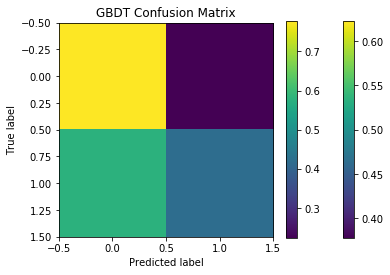

In [23]:
#gbdt, train
gbdt = GradientBoostingClassifier(max_depth=4,
                                  random_state=0,
                                  min_samples_split=5,
                                  learning_rate=0.01,
                                  n_estimators=30,
                                  subsample=0.8)

sample_weight = np.zeros(train_label.shape,np.float)
sample_weight[train_label==1] = 1.0 / np.sum(train_label==1)
sample_weight[train_label==0] = 1.0 / np.sum(train_label==0)
rf = gbdt.fit(train_feature_matrix, train_label, sample_weight)

print("train================================")

val_score_rbf = gbdt.score(train_feature_matrix, train_label)#val_score_rbf = gbdt.score(x, y)
print("The train accuracy score of rf is : %f" % val_score_rbf)
predict_label = gbdt.predict(train_feature_matrix)
prob_y = gbdt.predict_proba(train_feature_matrix)[:,1]
cm = confusion_matrix(predict_label,train_label)
print("confusion matrix is ", cm)
plot_confusion_matrix(cm, "GBDT Confusion Matrix")
print(" positive f1:",f1_score(train_label,predict_label,pos_label=True))
print(" negative f1:",f1_score(train_label,predict_label,pos_label=False))
#print('test_feature_matrix:',test_feature_matrix)
gbdt_auc = roc_auc_score(train_label, prob_y)
print('The AUC of GBDT: %.5f' % gbdt_auc)




print("test================================")
test_score_rbf = gbdt.score(test_feature_matrix, test_label)#test_score_rbf = gbdt.score(test_x, test_y)
print("The test accuracy score of rf is : %f" % test_score_rbf)
predict_label = gbdt.predict(test_feature_matrix)
prob_y = gbdt.predict_proba(test_feature_matrix)[:,1]
cm = confusion_matrix(predict_label,test_label)
print("confusion matrix is ", cm)
plot_confusion_matrix(cm, "GBDT Confusion Matrix")


print(" positive f1:",f1_score(test_label,predict_label,pos_label=True))
print(" negative f1:",f1_score(test_label,predict_label,pos_label=False))
from sklearn.metrics import precision_score, recall_score, f1_score
f1 = f1_score(test_label, predict_label, average='binary')
print("f1:", f1 )
p = precision_score(test_label, predict_label, average='binary')
print("precision:", p)
r = recall_score(test_label, predict_label,average='binary')
print("recall:", r)
#print('test_feature_matrix:',test_feature_matrix)
gbdt_auc = roc_auc_score(test_label, prob_y)
print('The AUC of GBDT: %.5f' % gbdt_auc)